In [1]:
%matplotlib inline
from astropy.io import ascii
import matplotlib.pyplot as plt; plt.ion()
import numpy as np
from mavisim import AstromCalibSimE2E
from PrototypingRead import AstrocalibRead
from PrototypingSim import CreateDist
import pandas as pd
from scipy import interpolate

%reload_ext autoreload
%autoreload 2

In [3]:
# input true distortion field:
static_distort =  ascii.read("./datav1_1/data/StaticDistortTransmissive")

# create the astrometry simulator object:
astrom_sim = AstromCalibSimE2E(
    static_distort,           # astropy parsed input file with appropriate headers
    hole_position_std=10e-6,   # manufacturing tolerance in mm.
    dx=1.0, dy=1.0,           # Shift applied to mask for differential method.
    n_poly=6)   
recovered_dist_xx,recovered_dist_yy = astrom_sim.recovered_dist(astrom_sim._p0_meas[:,0],astrom_sim._p0_meas[:,1])

data = pd.DataFrame({'home':[np.nan],'shiftx':[np.nan],'shifty':[np.nan]})
corners = pd.DataFrame({'data':[np.nan],'dimension':np.nan,'dx':np.nan,'dy':np.nan})
sim = AstrocalibRead(data,corners,'C')

## Manual Distortion

In [255]:
dist = CreateDist(dist_samp=31,dxdy=0.1,num_shifts=10,rand_scale=4e-3,std=10,N_poly=6,centroid_noise_std=0)

In [257]:
p1=[10,10]
p2=[11,10.1]
lim=[30,30] #specify the desired x and y dimension, 30 means from -15 to +15.
x,y = sim._make_hex_grid(p1,p2,lim)
x = x-15
y = y-15

# Plot the points
#plt.figure(figsize=[10,10])
#plt.plot(x, y, '.b')
#plt.gca().set_aspect('equal', adjustable='box')

#plt.xlabel('X')
#plt.ylabel('Y')
#plt.title('Isometric Grid of Points')
#plt.show()

dist.do_uhat_interp(x,y,plot='no')

Input spatial Distortion RMS: 0.003930391533884328
Fitted Distortion RMS: 0.003948988664194147
Residual Distortionh RMS: 0.004385067327738952
...
Reperforming DAC using the calculated polynomial coefficients as the distortion:
Input U_hat Distortion RMS: 0.003948988664194147
Fitted Distortion RMS: 0.0039507823660851074
Residual Distortionh RMS: 2.2305022804464557e-06
Position recovery for Home Position Residual RMS: 2.230502280442819e-06
...
Reperforming DAC using the calculated polynomial coefficients as the distortion but with the interpolation method:
Input U_hat Interpolated Distortion RMS: 0.0033687160801668457
Fitted Distortion RMS: 0.0039428440174868774
Residual Distortionh RMS: 5.197610968302016e-06
Position recovery for Home Position Residual RMS: 5.19761096828837e-06


array([3., 3., 3.])

## Notes
#### Interpolation as an estimation of the distoriton field needs further work
#### Not sure how well the DAC method can fit distortion fields of different spatial frequency
#### Performing DAC on top of a distortion field generated by polynomial functions give a residual distortion with residual ~10^-9as
#### 50uas goal -> 5e-5
#### Make back up of all files
#### Upgrade everything into PrototypingSim
#### Check for the flipping of the field

## Part 2

In [ ]:
# Evaluate astrometric error between objects
n_objects    = 1000
objects      = np.random.random([n_objects,2])*30-15
#print(objects)
filt_objects = ((objects**2).sum(axis=1)**0.5)<=5.0
#print(filt_objects)
objects      = objects[filt_objects,:]
n_objects    = objects.shape[0]
dists = []
errs  = []
for i in range(n_objects):
    for j in range(i):
        ob1 = objects[i,:]
        ob2 = objects[j,:]
        true_distance = np.linalg.norm(ob1-ob2)
        meas_distance = np.linalg.norm(ob1-ob2+astrom_sim.residual_dist(ob1[0],ob1[1])-astrom_sim.residual_dist(ob2[0],ob2[1]))
        dists.append(true_distance)
        errs.append(true_distance-meas_distance)
dists = np.r_[dists]
errs  = np.r_[errs]
plt.figure(figsize=[5,5])
plt.plot(dists,np.abs(errs)*1e6,"b.")
plt.axline(np.r_[0,0],slope=50/1,linestyle=":",color="k")
plt.axline(np.r_[0,0],slope=150/1,linestyle="-",color="k")
plt.legend(["Astrometric Error","Goal Accuracy","Req Accuracy"])
plt.xlim([0,5])
plt.ylim([0,400])
plt.title("Astrometric Error vs Distance")
plt.xlabel("Separation [arcsec]")
plt.ylabel("Astrometric Error after calibration [uas]")
plt.show()

### Note: dx_meas gives different results if calculate (in comparison to original input)

## Old Codes

In [235]:

#Random distortion with spatial correlations
def gen_dist(n_points=20,std=5,dist_rms=4e-5,plot='no'):
    #n_points:  number of points in each grid dimension
    #std:  spatial covariance modelled as gaussian with std: (higher std = more spatially correlated)

    # create a grid and centre it at (0,0)
    xx,yy = np.meshgrid(np.linspace(-17, 17, n_points),np.linspace(-17, 17, n_points),indexing="xy")
    xx = xx - xx.mean()
    xx = xx.flatten()
    yy = yy - yy.mean()
    yy = yy.flatten()
    # build distance matrix from all points to all points:
    rr = ((xx[:,None]-xx[None,:])**2 + (yy[:,None]-yy[None,:])**2)**0.5
    # evaluate covariance matrix at distance matrix points:
    cov = 1/(std*(2*np.pi)**0.5)*np.exp(-0.5*rr**2/std**2)
    # factorise covariance matrix into "square root" form, so we can generate random realisations
    w,v = np.linalg.eigh(cov)
    filt = w>1e-7
    w = w[filt]
    v = v[:,filt]
    L = v @ np.diag(w**0.5)
    # generate normally distributed random input (one each for x and y):
    v = np.random.randn(L.shape[1],2)
    # map it to random variable with desired covariance:
    d = L @ v
    # plot
    if plot=='yes':
        for i in range(xx.shape[0]):
            plt.arrow(xx[i],yy[i],d[i,0],d[i,1],width=0.05,color='c')
        plt.axis("equal")
    return d*dist_rms/np.mean(np.abs(d))
#Distortion function based on the DAC coefficients
def u_hat_dist(xx,yy,uhat,n_poly): 
    def _recovered_distortions_ana(N):
        n_tot_poly = ((N+1)*(N+2))//2-1
        u_hat = uhat
        return lambda x,y: np.c_[sim._hbvpoly(np.c_[x,y],u_hat[:n_tot_poly]),
                                 sim._hbvpoly(np.c_[x,y],u_hat[n_tot_poly:])]
    out_xx = xx*0
    out_yy = xx*0
    for i in range(xx.shape[0]):
        #func_handle = self._recovered_distortions_ana(self._home_pos,self._shiftx_pos,self._shifty_pos,n_poly,self._dx_meas_x,self._dy_meas_y)
        func_handle = _recovered_distortions_ana(n_poly)
        out_xx[i],out_yy[i] = func_handle(xx[i],yy[i])[0]
    return np.c_[out_xx,out_yy]
def Create_Dist(*,nsamp=31, dist_samp=15,dxdy=0.5,num_shifts=2,rand_scale=10e-5,std=5,N_poly=6,mode='random',plot='no',int_test='no'):
    #for j in [5,10,15,20,25,30,35]:
    # Create a grid of data points
    x_rand = np.linspace(-17, 17, dist_samp)  # X-coordinates
    y_rand = np.linspace(-17, 17, dist_samp)  # Y-coordinates

    random_dist_x = gen_dist(n_points=dist_samp,std=std,dist_rms=rand_scale)[:,0].reshape(dist_samp,dist_samp)
    random_dist_y = gen_dist(n_points=dist_samp,std=std,dist_rms=rand_scale)[:,1].reshape(dist_samp,dist_samp)

    # Define the interpolation function using RectBivariateSpline
    dist_func_x = interpolate.RectBivariateSpline(x_rand, y_rand, random_dist_x,kx=1,ky=1)
    dist_func_y = interpolate.RectBivariateSpline(x_rand, y_rand, random_dist_y,kx=1,ky=1)


    

    #Generate a unit circle to determine the shifting amount
    angles = np.linspace(0, 2 * np.pi, num_shifts, endpoint=False)

    # Calculate the x and y coordinates of the points using trigonometry
    x_ang = np.cos(angles)
    y_ang = np.sin(angles)

    # Create a list of (x, y) tuples representing the points
    if num_shifts == 1:
        print('Provide a num_shifts number greater than 1')
    elif num_shifts == 2:
        circ_points = np.array([[dxdy,0],[0,dxdy]])
    else:
        circ_points = np.array([(x_ang[i], y_ang[i]) for i in range(num_shifts)]) * dxdy
    ###############
    ###############
    ###############
    ###############

    #Create new coordinates
    # Values to evaluate distortion functions with. Can be any arangement of 
    # coordinates within the science field.


    x_linspace = np.linspace(-17,17,nsamp)
    y_linspace = np.linspace(-17,17,nsamp)
    x_mesh,y_mesh = np.meshgrid(x_linspace,y_linspace)
    x_flattened = x_mesh.flatten()
    y_flattened = y_mesh.flatten()



    #Home Distortions
    spatial_dist_h = np.c_[(dist_func_x(y_flattened,x_flattened,grid=False)), 
                           (dist_func_y(y_flattened,x_flattened,grid=False))] #Need to reverse x and y due to the nature of the interpolation function
    mavis_dist_xx_h,mavis_dist_yy_h = astrom_sim.input_dist(x_flattened,y_flattened)
    mavis_dist_h = np.c_[mavis_dist_xx_h,mavis_dist_yy_h]

    #Shifted Distortions
    shifted_dist = np.zeros([len(circ_points),np.shape(spatial_dist_h)[0],np.shape(spatial_dist_h)[1]])
    mavis_shifted_dist = np.zeros([len(circ_points),np.shape(mavis_dist_h)[0],np.shape(mavis_dist_h)[1]])

    for i in range(len(circ_points)):
        x_points = x_flattened + circ_points[i][0]
        y_points = y_flattened + circ_points[i][1]
        shifted_dist[i] = np.c_[(dist_func_x(y_points,x_points,grid=False)),
                                (dist_func_y(y_points,x_points,grid=False))]
        
        xx_points = x_flattened + circ_points[i][0]
        yy_points = y_flattened + circ_points[i][1]
        mavis_dist_xx,mavis_dist_yy = astrom_sim.input_dist(xx_points,yy_points)
        mavis_shifted_dist[i] = np.c_[mavis_dist_xx,mavis_dist_yy]

    

    if mode=='MAVIS':
        home_dist = mavis_dist_h
        home_meas = np.c_[x_flattened,y_flattened] + home_dist
        shiftxy_meas = mavis_shifted_dist + np.c_[x_flattened,y_flattened] + circ_points[:,None]
        print('Input MAVIS Distortion RMS:', np.mean(np.abs(home_dist)))
    elif mode=='spatial':
        home_dist = spatial_dist_h
        home_meas = np.c_[x_flattened,y_flattened] + home_dist
        shiftxy_meas = shifted_dist + np.c_[x_flattened,y_flattened] + circ_points[:,None]
        print('Input spatial Distortion RMS:', np.mean(np.abs(home_dist)))
    elif mode == 'hybrid':
        home_dist = mavis_dist_h + spatial_dist_h
        home_meas = np.c_[x_flattened,y_flattened] + home_dist 
        shiftxy_meas = mavis_shifted_dist + shifted_dist + np.c_[x_flattened,y_flattened] + circ_points[:,None]
        print('Input MAVIS Distortion RMS:', np.mean(np.abs(mavis_dist_h)))
        print('Input spatial Distortion RMS:', np.mean(np.abs(spatial_dist_h)))
        print('Input total Distortion RMS:', np.mean(np.abs(home_dist)))
    else:
        print('Enter mode="MAVIS", mode="spatial", or mode="hybrid"')
        
        
    #Perform DAC
    home1_distx, home1_disty = sim.recovered_dist_manual(x_flattened,y_flattened,home_meas,shiftxy=shiftxy_meas,dxy_meas=circ_points,n_poly=N_poly,r=30)
    
    print('Fitted Distortion RMS:',np.mean(np.abs( np.c_[home1_distx,home1_disty])))
    print('Residual Distortionh RMS:',np.mean(np.abs(home_dist - np.c_[home1_distx,home1_disty])))

    ######################
    ######################
    ######################


    print('...')
    print('Reperforming DAC using the calculated polynomial coefficients as the distortion:')

    u_hat_dist_h = u_hat_dist(x_flattened,y_flattened,sim._u_hat,N_poly)
    u_hat_dist_shifted = np.zeros([len(circ_points),u_hat_dist_h.shape[0],u_hat_dist_h.shape[1]])
    for j in range(len(circ_points)):
        xx_points = x_flattened + circ_points[j][0]
        yy_points = y_flattened + circ_points[j][1]
        u_hat_dist_shifted[j] = u_hat_dist(xx_points,yy_points,sim._u_hat,N_poly)
    
    
    uhat_home_meas = np.c_[x_flattened,y_flattened] + u_hat_dist_h
    uhat_shiftxy_meas = u_hat_dist_shifted + np.c_[x_flattened,y_flattened] + circ_points[:,None]
    print('Input U_hat Distortion RMS:', np.mean(np.abs(u_hat_dist_h)))


     #Perform DAC
    uhat_home_distx, uhat_home_disty = sim.recovered_dist_manual(x_flattened,y_flattened,uhat_home_meas,shiftxy=uhat_shiftxy_meas,dxy_meas=circ_points,n_poly=N_poly,r=30)
    
    
    print('Fitted Distortion RMS:',np.mean(np.abs( np.c_[uhat_home_distx,uhat_home_disty])))
    print('Residual Distortionh RMS:',np.mean(np.abs(np.c_[uhat_home_distx,uhat_home_disty] - np.c_[home1_distx,home1_disty])))
    
    pos_res = uhat_home_meas - np.c_[uhat_home_distx, uhat_home_disty] - np.c_[x_flattened, y_flattened]
    print('Position recovery for Home Position Residual RMS:',np.mean(np.abs(pos_res)))


    ######################
    ######################
    ######################
    if int_test == 'yes':

        print('...')
        print('Reperforming DAC using the calculated polynomial coefficients as the distortion but with the interpolation method:')


        x_uhat_mesh, y_uhat_mesh = np.meshgrid(x_rand,y_rand)
        x_uhat_mesh_flattened = x_uhat_mesh.flatten()
        y_uhat_mesh_flattened = y_uhat_mesh.flatten()


        u_hat_interp_dist_gen = u_hat_dist(x_uhat_mesh_flattened,y_uhat_mesh_flattened,sim._u_hat,N_poly)
        u_hat_dist_gen_xreshape = u_hat_interp_dist_gen[:,0].reshape(dist_samp,dist_samp)
        u_hat_dist_gen_yreshape = u_hat_interp_dist_gen[:,1].reshape(dist_samp,dist_samp)


        # Define the interpolation function using RectBivariateSpline
        uhat_dist_func_x = interpolate.RectBivariateSpline(x_rand, y_rand, u_hat_dist_gen_xreshape,kx=1,ky=1)
        uhat_dist_func_y = interpolate.RectBivariateSpline(x_rand, y_rand, u_hat_dist_gen_yreshape,kx=1,ky=1)



        #Home Distortion
        #uhat_interp_dist_h = np.c_[(uhat_dist_func_x(x_linspace,y_linspace)).flatten(), 
        #                        (uhat_dist_func_y(x_linspace,y_linspace)).flatten()]
        uhat_interp_dist_h = np.c_[uhat_dist_func_x(y_flattened,x_flattened,grid=False), 
                                   uhat_dist_func_y(y_flattened,x_flattened,grid=False)]
        #Shifted Distortions
        uhat_interp_shifted_dist = np.zeros([len(circ_points),np.shape(uhat_interp_dist_h)[0],np.shape(uhat_interp_dist_h)[1]])

        
        for k in range(len(circ_points)):
            #x_points = x_linspace + circ_points[k][0]
            #y_points = y_linspace + circ_points[k][1]
            x_points = x_flattened + circ_points[k][0]
            y_points = y_flattened + circ_points[k][1]
            uhat_interp_shifted_dist[k] = np.c_[uhat_dist_func_x(y_points,x_points,grid=False),
                                                uhat_dist_func_y(y_points,x_points,grid=False)]
        
        
        uhat_interp_home_meas = np.c_[x_flattened,y_flattened] + uhat_interp_dist_h
        uhat_interp_shiftxy_meas = uhat_interp_shifted_dist + np.c_[x_flattened,y_flattened] + circ_points[:,None]
        print('Input U_hat Interpolated Distortion RMS:', np.mean(np.abs(uhat_interp_dist_h)))

        #Perform DAC
        uhat_interp_home_distx, uhat_interp_home_disty = sim.recovered_dist_manual(x_flattened,y_flattened,uhat_interp_home_meas,shiftxy=uhat_interp_shiftxy_meas,dxy_meas=circ_points,n_poly=N_poly,r=30)
        
        
        print('Fitted Distortion RMS:',np.mean(np.abs( np.c_[uhat_interp_home_distx,uhat_interp_home_disty])))
        print('Residual Distortionh RMS:',np.mean(np.abs(np.c_[uhat_interp_home_distx,uhat_interp_home_disty] -uhat_interp_dist_h)))

        pos_res2 = uhat_interp_home_meas - np.c_[uhat_interp_home_distx, uhat_interp_home_disty] - np.c_[x_flattened, y_flattened]
        print('Position recovery for Home Position Residual RMS:',np.mean(np.abs(pos_res2)))


    ######################   
    ######################
    ###################### 


    if plot=='yes':
        # plot residual
        plt.figure(figsize=[8,8])
        arrow_sf = 100
        Distortion_scale = np.sqrt(np.mean(home1_distx**2+home1_disty**2))*1000
        for i in range(x_flattened.shape[0]):
            plt.arrow(x_flattened[i],y_flattened[i],arrow_sf*uhat_interp_dist_h[:,0][i],arrow_sf*uhat_interp_dist_h[:,1][i],
                      color="r",head_width=0.05,width=0.01,length_includes_head=True)   
        for j in range(x_flattened.shape[0]):    
            #plt.arrow(x_flattened[i],y_flattened[i],arrow_sf*home_dist[:,0][i],arrow_sf*home_dist[:,1][i],
            #        color="r",head_width=0.05,width=0.01,length_includes_head=True)
            #plt.arrow(x_flattened[i],y_flattened[i],arrow_sf*home1_distx[i],arrow_sf*home1_disty[i],
                    #color="b",head_width=0.05,width=0.01,length_includes_head=True)
            #plt.arrow(x_flattened[i],y_flattened[i],arrow_sf*uhat_home_distx[i],arrow_sf*uhat_home_disty[i],
                    #color="g",head_width=0.05,width=0.01,length_includes_head=True)
            #plt.arrow(x_flattened[i],y_flattened[i],arrow_sf*uhat_interp_home_distx[i],arrow_sf*uhat_interp_home_disty[i],
            #        color="y",head_width=0.05,width=0.01,length_includes_head=True)
            plt.arrow(x_flattened[j],y_flattened[j],arrow_sf*u_hat_interp_dist_gen[:,0][j],arrow_sf*u_hat_interp_dist_gen[:,1][j],
                      color="b",head_width=0.05,width=0.01,length_includes_head=True)
                     
            plt.axis("square")
        plt.legend(["true distortion","interpolated distortion"])
        plt.title(f"Field Distortion\n(arrows scaled {arrow_sf:0.0f}x)\n(Distortion RMS {Distortion_scale*1000:0.02f}uas)")
        plt.xlabel("x-position in field [arcsec]")
        plt.ylabel("y-position in field [arcsec]")
        plt.show()

        
    return u_hat_interp_dist_gen, uhat_interp_dist_h, x_rand, y_rand, x_flattened, y_flattened

In [236]:
u_hat_interp_dist_gen, uhat_interp_dist_h = Create_Dist(nsamp=21,dist_samp=21,dxdy=1,std=5,num_shifts=10,rand_scale=4e-3,N_poly=6,mode='spatial',int_test='yes',plot='no')
#home_meas2, home_distx2, home_disty2, x_flattened, y_flattened = Create_Dist(nsamp=16,dist_samp=5,dxdy=0.1,std=5,num_shifts=10,rand_scale=4e-5,N_poly=6,mode='spatial',plot='no')
#home_meas3, home_distx3, home_disty3, x_flattened, y_flattened = Create_Dist(nsamp=16,dist_samp=5,dxdy=0.1,std=5,num_shifts=10,rand_scale=4e-5,N_poly=6,mode='spatial',plot='no')


Input spatial Distortion RMS: 0.0038118337029891835
Fitted Distortion RMS: 0.004199406454509754
Residual Distortionh RMS: 0.003958895790647802
...
Reperforming DAC using the calculated polynomial coefficients as the distortion:
Input U_hat Distortion RMS: 0.004199406454509754
Fitted Distortion RMS: 0.004173754550195733
Residual Distortionh RMS: 3.4152678805777254e-05
Position recovery for Home Position Residual RMS: 3.415267880579023e-05
...
Reperforming DAC using the calculated polynomial coefficients as the distortion but with the interpolation method:
Input U_hat Interpolated Distortion RMS: 0.004173754550195733
Fitted Distortion RMS: 0.00401375060413342
Residual Distortionh RMS: 0.00032765256767838124
Position recovery for Home Position Residual RMS: 0.00032765256767842244


ValueError: too many values to unpack (expected 2)

In [242]:
x_rand = np.linspace(-5,5,4)
y_rand = np.linspace(-5,5,4)
x_uhat_mesh, y_uhat_mesh = np.meshgrid(x_rand,y_rand)
x_uhat_mesh_flattened = x_uhat_mesh.flatten()
y_uhat_mesh_flattened = y_uhat_mesh.flatten()


u_hat_interp_dist_gen = np.array([[1,2],[1,2],[1,2],[1,2],
                                  [1,2],[1,2],[1,2],[1,2],
                                  [1,2],[1,2],[1,2],[1,2],
                                  [1,2],[1,2],[1,2],[1,2]])
u_hat_interp_dist_gen = np.random.rand(16,2)
u_hat_dist_gen_xreshape = u_hat_interp_dist_gen[:,0].reshape(4,4)
u_hat_dist_gen_yreshape = u_hat_interp_dist_gen[:,1].reshape(4,4)


# Define the interpolation function using RectBivariateSpline
uhat_dist_func_x = interpolate.RectBivariateSpline(y_rand, x_rand, u_hat_dist_gen_xreshape,kx=1,ky=1)
uhat_dist_func_y = interpolate.RectBivariateSpline(y_rand, x_rand, u_hat_dist_gen_yreshape,kx=1,ky=1)



#Home Distortion
#uhat_interp_dist_h = np.c_[(uhat_dist_func_x(x_linspace,y_linspace)).flatten(), 
#                        (uhat_dist_func_y(x_linspace,y_linspace)).flatten()]
uhat_interp_dist_h = np.c_[uhat_dist_func_x(x_uhat_mesh_flattened,y_uhat_mesh_flattened,grid=False), 
                           uhat_dist_func_y(x_uhat_mesh_flattened,y_uhat_mesh_flattened,grid=False)]

print(u_hat_interp_dist_gen)
print(uhat_interp_dist_h)

[[0.4184168  0.57375471]
 [0.93795491 0.34237665]
 [0.70087536 0.88082156]
 [0.27051618 0.49392538]
 [0.79885847 0.50628958]
 [0.05128816 0.29412668]
 [0.63192474 0.31472519]
 [0.0421091  0.30545645]
 [0.95087565 0.60656645]
 [0.04802349 0.04010822]
 [0.31246854 0.75233199]
 [0.60321216 0.97469612]
 [0.52695232 0.50116503]
 [0.48278872 0.25451743]
 [0.26393093 0.24950847]
 [0.45265016 0.47345885]]
[[0.4184168  0.57375471]
 [0.79885847 0.50628958]
 [0.95087565 0.60656645]
 [0.52695232 0.50116503]
 [0.93795491 0.34237665]
 [0.05128816 0.29412668]
 [0.04802349 0.04010822]
 [0.48278872 0.25451743]
 [0.70087536 0.88082156]
 [0.63192474 0.31472519]
 [0.31246854 0.75233199]
 [0.26393093 0.24950847]
 [0.27051618 0.49392538]
 [0.0421091  0.30545645]
 [0.60321216 0.97469612]
 [0.45265016 0.47345885]]


0 | 4.516e-03
1 | 4.556e-03
2 | 4.554e-03
3 | 4.479e-03
4 | 4.341e-03
5 | 4.199e-03
6 | 4.108e-03
7 | 4.137e-03
8 | 4.258e-03
9 | 4.400e-03


(-17.599118051927732,
 17.625414628884187,
 -17.612001050302162,
 17.612531630509757)

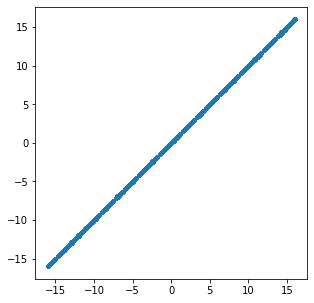

In [170]:
#print(u_hat_dist_h, uhat_interp_dist_h)
i=0
for i in range(10):
    print(f"{i:d} | {np.std(u_hat_dist_shifted[i].flatten()-uhat_interp_shifted_dist[i].flatten()):0.3e}")
plt.figure(figsize=[5,5])
#plt.plot(u_hat_dist_h.flatten(),uhat_interp_dist_h.flatten(),".")
#plt.plot(u_hat_dist_shifted[:].flatten(),uhat_interp_shifted_dist[:].flatten(),".")
plt.plot(uhat_shiftxy_meas[:].flatten(),uhat_interp_shiftxy_meas[:].flatten(),".")
plt.axis("square")
#plt.axline([0,0],[0.2,0.2])
#plt.xlim([-0.01,0.02])
#plt.ylim([-0.01,0.02])


In [171]:
np.allclose(uhat_shiftxy_meas,uhat_interp_shiftxy_meas)

False